## The task

Investigate potential features you could extract from a given URL, and implement extractors for the ones that interest you the most. The example code below extracts one feature, but does not store it very efficiently (just console logs it). Implement a sensible data structure using some known data structure library to store the features per URL. Choose one feature for which you can visualise the results. What does the visualisation tell you? Also consider how you would approach error handling, if one of the feature extractor fails?

### Importing the necessary libraries

In [350]:
import requests
import json
from urllib.parse import urlparse
import validators
import pandas as pd
import os
import idna
from lxml import etree
from lxml.html import fromstring
import whois
import datetime
from requests_html import HTMLSession
from collections import Counter
import time
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# loading Alexa top ranking websites from a local file
alexa_csv = 'top-1m.csv'
a_exists = alexa_csv in os.listdir()

if a_exists:
    alexa = pd.read_csv(alexa_csv, header = None).rename({0: 'ranking', 1: 'domain'}, axis = 1)
else:
    print('Won\'t be able to retrieve Alexa ranking of URLs')

### Defining functions for URL analysis

In [2]:
# retrieveing domain age in days 

def get_domain_age(domain):
    show = "https://input.payapi.io/v1/api/fraud/domain/age/" + domain
    data = requests.get(show).json()
    return data['result'] if 'result' in data else None

In [4]:
# counting dots in free URL

def count_dots(url, domain):
    start = url.find(domain)
    end = start + len(domain)
    return (url[:start] + url[end:]).count('.')

In [5]:
# if the domain is ranked in Alexa, return its position, otherwise return 1 000 001

def alexa_rating(domain):
    if domain not in alexa.domain.tolist():
        return int(1e6+1)
    return alexa[alexa.domain == domain].ranking.tolist()[0]

In [14]:
'''
Detect punycode in a given domain. 
For example, аpple.com is a technically valid domain whose first character is cyrillic 'а'

'''
def contains_punycode(domain):
    x = idna.encode(domain)
    x.decode('utf-8') == domain
    return x.decode('utf-8') != domain   

In [427]:
# parse information on Organization, Country, Name, Registrar, Creation Date and Expiration Date from who.is API

def parse_whois(domain):
    res = []
    try:
        info = whois.whois(domain)
    except (whois.socket.gaierror, whois.parser.PywhoisError):
        print('No WhoIs match for', domain)
        return [None] * 6
    except whois.socket.timeout:
        print('Couldn\'t reach', domain)
        return [None] * 6
    except whois.parser.ConnectionResetError:
        return('wait')
    for term in ['org', 'country', 'name', 'registrar']:
        if term in info and term in info.keys():
            res.append(info[term])
        else:
            res.append(None)
    for term in ['creation_date', 'expiration_date']:
        if term in info and term in info.keys() and info[term] != None:
            if isinstance(info[term], list):
                res.append(str(info[term][-1].date()))
            else:
                res.append(str(info[term].date()))
        else:
            res.append(None)
    return res

In [ ]:
# parse information on URL structure
def parse_url(url):
    parsed_url = urlparse(url)
    protocol = parsed_url.scheme
    domain = '.'.join(parsed_url.netloc.split('.')[-2:])
    subdomains = parsed_url.netloc.split('.')[:-2]
    if isinstance(subdomains, list):
        subdomains_count = len(subdomains)
        subdomains = ', '.join(subdomains)
    else:
        subdomains_count = 1
    return [protocol, domain, subdomains, subdomains_count]

In [389]:
# count external (redirecting to other domains) and internal links
def count_links(url):
    e_links = 0
    i_links = 0
    session = HTMLSession()
    try:
        r = session.get(url)
        domain = parse_url(url)[1]
        unique_links = Counter(urlparse(link).netloc for link in r.html.absolute_links)
        for link in unique_links:
            if '.'.join(link.split('.')[-2:]) != domain:
                e_links += 1
            else:
                i_links += 1
    except requests.ConnectionError:
        pass
    except lxml.etree.ParserError:
        pass
        
    return [e_links, i_links]

In [390]:
'''
Parse title, number of redirections from a given url, landing URL, number of images on page 
and whether the page contains password input field
'''

def retrieve_page_info(url):
    
    try:
        resp = requests.get(url)
        if resp.history:
            redirections = len(resp.history)
        else:
            redirections = 0
        tree = fromstring(resp.content)
        title = tree.findtext('.//title')
        parser = etree.HTMLParser()
        root = etree.fromstring(resp.content, parser = parser)
        img_count = int(root.xpath('count(//img)'))    
        if root.find('.//input[@type="password"]') != None:
            password_fields = True
        else:
            password_fields = False
            
        return [title, redirections, resp.url, img_count, password_fields]
    
    except requests.ConnectionError:
        print("Can't establish connection to", url) 
        return None
    except lxml.etree.ParserError:
        print("Couldn't parse", url)
        return None

In [291]:
# extract features with the defined above functions

def url_features(url):
        protocol, domain, subdomains, subdomains_count = parse_url(url)
        dot_count = count_dots(url, domain)
        age_in_days = get_domain_age(domain)
        fqdn_length = len(urlparse(url).netloc)
        mld_length = len(domain.split('.')[0])
        if a_exists:
            alexa_rank = alexa_rating(domain)
        else:
            alexa_rank = None
        return [url, len(url), protocol, domain, subdomains, subdomains_count,
                fqdn_length, mld_length, age_in_days, dot_count, alexa_rank]

### The main function to perform analysis

In [396]:
def analyze_url(url):
    
    # only proceed if a given string does look like a URL
    
    if not validators.url(url):
        print(url, 'doesn\'t look like a valid URL')
        return None
    
    result = []
    url_info_start = url_features(url)
    
    # retrieve features on the starting URL
    result.extend(url_info_start)
    result.append(contains_punycode(url_info_start[3]))
    
    page_info = retrieve_page_info(url)
    
    # check if the URL redirects to another URL, then retrieve the same features for it
    # if there is no redirection, append the same set of features
    
    if page_info != None:
        land_url = page_info[2]
        
        # omit the landing URL as it will be retrievevd by url_features later
        result.extend(page_info[:2])
        result.extend(page_info[3:])
    else:
        land_url = url
        
        # fill in the missing fields
        result.extend([None] * 4)

    url_info_land = url_features(land_url)
    result.extend(url_info_land)
    result.append(contains_punycode(url_info_land[3]))
    
    whois_info_start = parse_whois(url_info_start[3])
    while whois_info_start == 'wait':
        print('Too many requests, making a break...')
        time.sleep(10)
        whois_info_start = parse_whois(url_info_start[3])
    result.extend(whois_info_start)
    whois_info_land = parse_whois(url_info_land[3])
    while whois_info_land == 'wait':
        print('Too many requests, making a break...')
        time.sleep(15)
        whois_info_land = parse_whois(url_info_land[3])
    result.extend(whois_info_land)
    
    result.extend(count_links(land_url))

    return result

In [370]:
# expanded a toy dataset with some fresh links from https://www.phishtank.com/ and with some harmless URLs

urls = ['https://bit.ly/3rdwo3N',
 'https://emiratesminning.com/fend.php',
 'https://jh-infotech.com/assume.php',
 'http://gde.cz/je/a7r',
 'https://hj.vc/THK2',
 'https://bbmanzc.xyz/',
 'https://cutt.ly/zlZIX5W',
 'http://sdtrauma.com/css/orange/4f196/index2.html',
 'https://lllll5992992003-388k.weebly.com/',
 'https://www-bancaporitranet-interbanc21.pe/login',
 'https://rebrand.ly/itb1oc6',
 'https://eurotransmarine-logistics.com/peripatetic.php',
 'https://crypto-mails.wixsite.com/my-site',
 'https://inlineaviationgroup.com/antidiuretic.php',
 'https://dotpay-platnosc3.eu/dotpay/',
 'http://legalshield.avpsro.eu/',
 'https://www.amazon.de/-/en/Aricola-Matcha-pieces-consisting-matcha/dp/B01K4WHRFY/',
 'https://gazetka24.laohost.net',
 'https://theheartforheartprogram.org/.bga',
 'https://www.kaggle.com/dansbecker/food-101',
 'https://dsn16888.cn/',
 'https://jaforiqbal.com/vitreous.php',
 'https://bgurbanglam.com/wooziness.php',
 'https://antiviral-tapes.000webhostapp.com/',
 'https://dsgj16888.cn/',
 'https://hmmmithumus.com/ZkcdwHRT',
 'https://ladelfina-bungalowsyspa.com.ar/ostracism.php',
 'https://fish-school.org/transmutable.php',
 'http://ce41557.tmweb.ru/mau/',
 'https://bw-bank.holdings/',
 'https://holidayobserve.com/cavalryman.php',
 'http://dgcmqmhwvedxyww.docushareportal8870.xyz/q1/',
 'https://www.coursera.org/learn/machine-learning/lecture/RKFpn/welcome',
 'http://bit.ly/edoardopolacco',
 'https://ladelfina-bungalowsyspa.com.ar/scissor.php',
 'https://maxmun.com/graze.php',
 'https://media1991.000webhostapp.com/',
 'http://wjcyg2moet0nr612l5sp0oxm.designmysite.pro/',
 'https://erestueldelvideo2.000webhostapp.com/',
 'http://bwbank.blog/',
 'https://iriti.net/watermarking.php',
 'https://www.hoxhunt.com/gamified-phishing-training-platform/',
 'https://el2.convertkit-mail.com/c/d0u4e80qoph0hd4859bm/25h2hoho5nvzwh/aHR0cHM6Ly9uYXZpZ2F0b3IudGhlcmVpc2FjYXVzZS5jb20vcGZncnN0YWx3Zm5oZm16dGlvaXR2L3d4b215dmF2Y25tYm5ja295bWR0cXNtd2pzcA=',
 'https://it-security.shemaree.com/shoreward.php',
 'https://hotrelaxation.com/986ds986f6sd69f68dsfsd986fds98.php',
 'https://cutty.ws/ydJSy',
 'https://firebasestorage.googleapis.com/v0/b/inshaaaaidmdkajnodabb.appspot.com/o/secondfile%20(4).HTML?alt=media&token=73a2d6af-a443-4e8c-9cf1-147a53fba42c#iuser@domain.cn',
 'https://bit.ly/3076d2u',
 'https://intezasanpaolo.com/',
 'https://www.slideshare.net/weaveworks/client-side-monitoring-with-prometheus',
 'https://losgedeones.com/unsolvable.php',
 'https://livenetworks.com.br/spots.php',
 'https://iriti.net/sergeancy.php',
 'https://it-security.shemaree.com/occasion.php',
 'https://secure273.inmotionhosting.com/~nbaeed5/29sv2onMN5/3XlExsnkh6/Q6t4etXvE2/62761e8d70ae7e9/',
 'https://dmt490002-ll499820222pdf.web.app/',
 'https://www.ozon.ru/product/tatis-arahisovaya-pasta-klassicheskaya-1-150-gr-175358532/',
 'https://secure273.inmotionhosting.com/~n4f8d85/access/freesub/2021/e806960534dc695/',
 'https://cutt.ly/guard/zlZIX5W',
 'https://server041990.nazwa.pl/payment.php',
 'https://coxupgragpage.wixsite.com/my-site',
 'https://lil.cm/2y3K2',
 'https://hellfalse.com/78asd78as8dsad966sa8d86sa86da986s.php',
 'http://bwbank.us/',
 'https://inuyuni.com/unsubstantiated.php',
 'https://main.ddvwj32jq95fa.amplifyapp.com/index.html#heathertipton@prepaidlegal.com',
 'https://inposta.pw/order/pl815230982',
 'https://inposta.pw/',
 'https://hgfoh876ufdt6u.weebly.com/',
 'https://attyahoo21server.weebly.com/',
 'https://hmb.cryptowaretech.co/slighted.php',
 'https://iglivesupportchannel.com/',
 'https://docs.google.com/document/d/e/2PACX-1vSxIeLpthPV6e3Yk1d6LMEBpRee0w_Fn0dFh_1wdo-AekQR3uqqlyzZ82TcTUyUddlMP6S_eNtpu6jT/pub',
 'https://maps.google.com/',
 'https://foodie.pretsl.com/susceptiveness.php',
 'https://refcommunateorange5.weebly.com/',
 'https://fafsaga.000webhostapp.com/',
 'https://server041990.nazwa.pl/ipko_payment.php',
 'https://olx.pl-cash.xyz/getpay/169030560',
 'https://pogoda.yandex.ru/',
 'https://hashtagvisual.com/decover.php',
 'https://impactmarketingservice.in/sleuth.php',
 'https://amazer.amazvomn.top/',
 'https://github.com/hslatman/awesome-threat-intelligence',
 'https://jayins.com/verbatim.php',
 'https://jpamazou.jpamazoun.xyz/',
 'http://президент.рф/',
 'https://harvestdescent.com/dsa96d69as986ds6d986sa986d986sa.php',
 'https://bw-bank.company/',
 'https://snowequipmentdealer.com/unsubscribe?redirect=oM3k0e',
 'http://weinnovateyourformofpeacefulintermatics.tk/innovatepeaceful/pac/',
 'https://sawahtutut10.wixsite.com/website',
 'https://freefireofficialtournament411.000webhostapp.com/',
 'https://fxcoinstrading.com/',
 'http://sec-login-device.com/',
 'https://hoponhopoff.escapetourism.co.nz/trilogy.php',
 'https://dero.grupo-briones.com/greenland.php',
 'http://server517854.nazwa.pl/payment.php',
 'http://college-eisk.ru/cli/',
 'https://rakutnqwp.xyz/certification_account',
 'https://bwbank.ink/',
 'https://www.ikea.fi/']

In [372]:
# so far a dataframe will store 42 features

df = pd.DataFrame(
    columns = ['url_start', 'url_length_start', 'protocol_start', 'domain_start', 'subdomains_start',
               'subdomains_count_start', 'fqdn_length_start', 'mld_length_start', 'age_start', 'dot_count_start', 
               'alexa_rank_start','has_punycode_start', 'page_title', 'redirections_count', 'img_count', 
               'password_fields', 'url_land', 'url_length_land', 'protocol_land', 'domain_land', 
               'subdomains_land', 'subdomains_count_land', 'fqdn_length_land', 
               'mld_length_land', 'age_land', 'dot_count_land', 'alexa_rank_land', 'has_punycode_land', 
               'org_start', 'country_start', 'whois_name_start', 'registrar_start', 'created_start',
               'expiring_start', 'org_land', 'country_land', 'whois_name_land', 'registrar_land',
               'created_land', 'expiring_land', 'external_links', 'internal_links' 
              ])

In [ ]:
for url in urls:
    result = analyze_url(url)
    if result != None:
        df.loc[len(df)] = result

In [469]:
# calculate the time between domain registration and its expiration date

df['whois_age'] = df.apply(lambda x: (datetime.datetime.strptime(x.expiring_start, '%Y-%m-%d') - 
                                      datetime.datetime.strptime(x.created_start, '%Y-%m-%d')).days 
                           if x.created_start != None and x.expiring_start != None else 0, axis = 1)

In [481]:
df.head()

,url_start,url_length_start,protocol_start,domain_start,subdomains_start,subdomains_count_start,fqdn_length_start,mld_length_start,age_start,dot_count_start,...,expiring_start,org_land,country_land,whois_name_land,registrar_land,created_land,expiring_land,external_links,internal_links,whois_age
0,https://bit.ly/3rdwo3N,22,https,bit.ly,,0,6,3,4672,0,...,2022-05-17,"Bitly, Inc.",US,None,"GoDaddy.com, LLC",2003-11-11,2021-11-11,2,1,5113
1,https://emiratesminning.com/fend.php,36,https,emiratesminning.com,,0,19,15,180,1,...,None,None,None,None,None,None,None,0,0,0
2,https://jh-infotech.com/assume.php,34,https,jh-infotech.com,,0,15,11,242,1,...,2022-07-04,"Domains By Proxy, LLC",US,Registration Private,"GoDaddy.com, LLC",2020-07-04,2022-07-04,0,0,730
3,http://gde.cz/je/a7r,20,http,gde.cz,,0,6,3,None,0,...,None,None,None,None,None,None,None,0,1,0
4,https://hj.vc/THK2,18,https,hj.vc,,0,5,2,None,0,...,2021-05-16,None,None,None,None,None,None,0,1,4018


In [480]:
df.tail()

,url_start,url_length_start,protocol_start,domain_start,subdomains_start,subdomains_count_start,fqdn_length_start,mld_length_start,age_start,dot_count_start,...,expiring_start,org_land,country_land,whois_name_land,registrar_land,created_land,expiring_land,external_links,internal_links,whois_age
94,http://server517854.nazwa.pl/payment.php,40,http,nazwa.pl,server517854,1,21,5,7740,2,...,2027-12-23,None,None,None,nazwa.pl sp. z o.o.,1999-12-24,2027-12-23,2,1,10226
95,http://college-eisk.ru/cli/,27,http,college-eisk.ru,,0,15,12,3429,0,...,2021-10-13,"FGOU SPO ""Kolledzh ""Eyskiy""",None,None,R01-RU,2011-10-13,2021-10-13,0,0,3653
96,https://rakutnqwp.xyz/certification_account,43,https,rakutnqwp.xyz,,0,13,9,0,0,...,2022-03-03,None,US,Super Privacy Service LTD c/o Dynadot,DYNADOT LLC,2021-03-03,2022-03-03,0,0,365
97,https://bwbank.ink/,19,https,bwbank.ink,,0,10,6,None,0,...,2022-03-01,"WhoisGuard, Inc.",PA,WhoisGuard Protected,NAMECHEAP INC,2021-03-01,2022-03-01,1,0,365
98,https://www.ikea.fi/,20,https,ikea.fi,www,1,11,4,4498,1,...,2021-08-15,Inter IKEA Systems B.V.,NL,Domain Administration,"CSC CORPORATE DOMAINS, INC.",1995-07-29,2021-07-05,0,2,4663


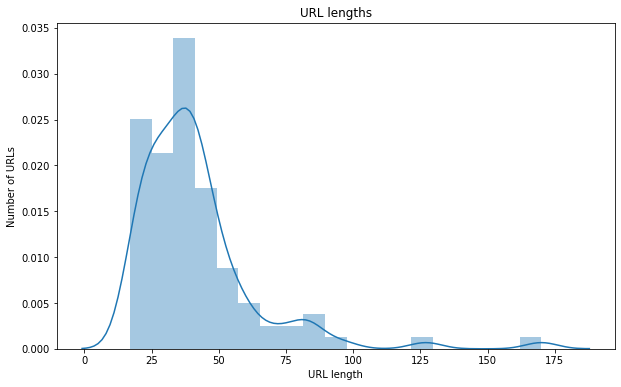

In [478]:
plt.figure(figsize = (10,6))
sns.distplot(df.url_length_start)
plt.title('URL lengths')
plt.xlabel('URL length')
plt.ylabel('Number of URLs')
plt.show()

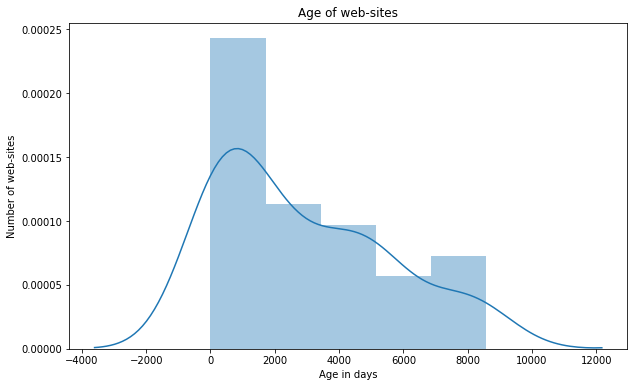

In [479]:
plt.figure(figsize = (10,6))
sns.distplot(df[df.age_start.isna() == False].age_start)
plt.title('Age of web-sites')
plt.xlabel('Age in days')
plt.ylabel('Number of web-sites')
plt.show()

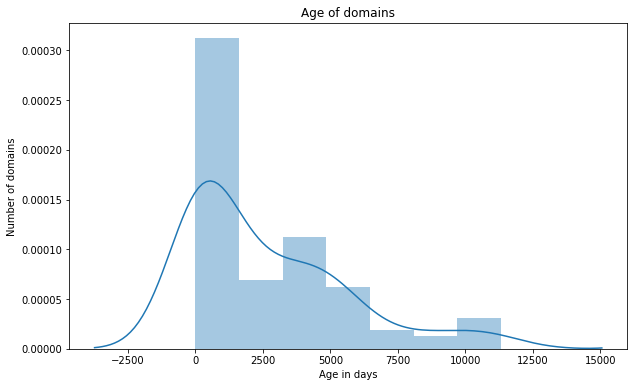

In [477]:

plt.figure(figsize = (10,6))
sns.distplot(df.whois_age)
plt.title('Age of domains')
plt.xlabel('Age in days')
plt.ylabel('Number of domains')
plt.show()